# Piecewise Polytropic Prior with ADM Example

The main purpose of this code is to demonstrate how one can fix the prior-likelihood to a constant value and use multinest to sample the prior space log-uniformly with asymmetric dark matter(ADM) present. Within this script, one can use the ``PosteriorAnalysis.py``script to generate the prior axuiliary data and the prior 95% confidence intervals. 


The following block of code will properly import NEoST and its prerequisites, furthermore it also defines a name for the inference run, this name is what will be prefixed to all of NEoST's output files.

The machinary used within this script and the explanation of them is identical to those found in the Piecewise Polytropic, Speed of Sound, and Tabulated Examples.

In [1]:
import neost
from neost.eos import polytropes
from neost.Prior import Prior
from neost.Star import Star
from neost.Likelihood import Likelihood
from neost import PosteriorAnalysis
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from pymultinest.solve import solve
import time
import os
if not os.path.exists("chains"): 
   os.mkdir("chains")

import neost.global_imports as global_imports

# Some physical constants
c = global_imports._c
G = global_imports._G
Msun = global_imports._M_s
pi = global_imports._pi
rho_ns = global_imports._rhons

Below, we define the piecewise polytripic equation of state model, import the J0740 likelihood function, set the ADM particle type to be a boson, and set whether we want to calculate ADM halos as well as the two-fluid tidal deformability. Note, both dm_halo and two_fluid_tidal are set to be False by default, so a user doesn't need to define them before-hand if they don't want to consider them in their inference. We wanted to highlight these parameters so that one knew where to define them in the event that either parameter were to be considered. 

In [2]:
# Define name for run
run_name = "prior-hebeler-pp-bosonic-adm-"

# We're exploring a polytropic (P) EoS parametrization with a chiral effective field theory (CEFT) parametrization based on Hebeler's work
# Transition between CS parametrisation and CEFT parametrization occurs at 1.1*saturation density
polytropes_pp = polytropes.PolytropicEoS(crust = 'ceft-Hebeler', rho_t = 1.1*rho_ns, adm_type = 'Bosonic',dm_halo = False,two_fluid_tidal = False)

Below, we define the piecewise polytripic equation of state model, import the J0740 likelihood function, and set the variable paramaeters with their respective prior space intervals depending on the their `adm_type` string parameter value. This is because the ADM priors are dependent on if one specifies that it is a boson or fermion.

In [3]:
# Create the likelihoods for the individual measurements
mass_radius_j0740 = np.load('j0740.npy').T
J0740_LL = gaussian_kde(mass_radius_j0740)

# Pass the likelihoods to the solver
likelihood_functions = [J0740_LL.pdf]
likelihood_params = [['Mass', 'Radius']]

# Define whether event is GW or not and define number of stars/events
chirp_mass = [None]
number_stars = len(chirp_mass)

# Define variable parameters, same prior as previous papers of Raaijmakers et al

print(polytropes_pp.adm_type)
if polytropes_pp.adm_type == 'Bosonic':
    variable_params={'ceft':[polytropes_pp.min_norm, polytropes_pp.max_norm],'gamma1':[1.,4.5],'gamma2':[0.,8.],'gamma3':[0.5,8.],'rho_t1':[1.5,8.3],'rho_t2':[1.5,8.3],
                    'mchi':[-2, 8],'gchi_over_mphi': [-3,3],'adm_fraction':[0., 5.]}
elif polytropes_pp.adm_type == 'Fermionic':
    variable_params={'ceft':[polytropes_pp.min_norm, polytropes_pp.max_norm],'gamma1':[1.,4.5],'gamma2':[0.,8.],'gamma3':[0.5,8.],'rho_t1':[1.5,8.3],'rho_t2':[1.5,8.3],
                    'mchi':[-2, 9],'gchi_over_mphi': [-5,3],'adm_fraction':[0., 1.7]}

if polytropes_pp.adm_type == 'None':
    variable_params={'ceft':[polytropes_pp.min_norm, polytropes_pp.max_norm],'gamma1':[1.,4.5],'gamma2':[0.,8.],'gamma3':[0.5,8.],'rho_t1':[1.5,8.3],'rho_t2':[1.5,8.3]}

#Note if the user wants to have a seperate adm_fraction per source, include it below via
#'adm_fraction_' + str(i+1):[0., 5.]. And eliminate the adm_fraction above, as that is to assume all Neutron stars have the same amount of adm_fraction
for i in range(number_stars):
	variable_params.update({'rhoc_' + str(i+1):[14.6, 16]})

# Define static parameters, empty dict because all params are variable 
static_params={}

Bosonic


Finally, the prior object must be created using the following function call:`neost.Prior.Prior(EOS, variable_params, static_params, chirp_masses)` where the `EOS` argument is the equation of state object that was created in the previous step. When this prior is called it will then uniformly sample sets of parameters from the defined parameter ranges.

The likelihood is defined by providing both the previously defined prior object and the likelihood functions defined in the previous codeblock. This is done with the following code: `likelihood = Likelihood(prior, likelihood_functions, likelihood_params, chirp_mass)`

In [4]:
# Define prior
prior = Prior(polytropes_pp, variable_params, static_params, chirp_mass)
likelihood = Likelihood(prior, likelihood_functions, likelihood_params, chirp_mass)

print("Bounds of prior are")
print(variable_params)
print("number of parameters is %d" %len(variable_params))


Bounds of prior are
{'ceft': [1.676, 2.814], 'gamma1': [1.0, 4.5], 'gamma2': [0.0, 8.0], 'gamma3': [0.5, 8.0], 'rho_t1': [1.5, 8.3], 'rho_t2': [1.5, 8.3], 'mchi': [-2, 8], 'gchi_over_mphi': [-3, 3], 'adm_fraction': [0.0, 5.0], 'rhoc_1': [14.6, 16]}
number of parameters is 10


## When finished with testing your likelihood and prior you can proceed to the actual inference process. This is done in the code block below. Warning: depending on the performance of your platform, this might be a very slow process. To make it slightly faster, we have decreased the number of live points and set a maximum number of iterations for this example. For a proper analysis, we would remove the max_iter argument and set, for example, n_live_points=30000.

In [5]:
# Then we start the sampling, note the greatly increased number of livepoints, this is required because each livepoint terminates after 1 iteration
start = time.time()
result = solve(LogLikelihood=likelihood.loglike_prior, Prior=prior.inverse_sample, n_live_points=1000, evidence_tolerance=0.1,
               n_dims=len(variable_params), sampling_efficiency=0.8, outputfiles_basename='chains/' + run_name, verbose=True, resume = False)
end = time.time()
print(end - start)

 *****************************************************
 MultiNest v3.10
 Copyright Farhan Feroz & Mike Hobson
 Release Jul 2015

 no. of live points = 1000
 dimensionality =   10
 *****************************************************
 Starting MultiNest
 generating live points
 live points generated, starting sampling
Acceptance Rate:                        1.000000
Replacements:                               1000
Total Samples:                              1000
Nested Sampling ln(Z):            **************
Importance Nested Sampling ln(Z):       1.000000 +/-  0.000000
  analysing data from chains/prior-hebeler-pp-bosonic-adm-.txt
 ln(ev)=   1.0000000000000000      +/-   2.5809568279517849E-009
 Total Likelihood Evaluations:         1000
 Sampling finished. Exiting MultiNest
1263.180106639862


In [6]:
PosteriorAnalysis.compute_prior_auxiliary_data('chains/' + run_name, polytropes_pp,
                                        variable_params, static_params,dm = True)

Total number of samples is 1000
sample too small for 28551303846789276.00
sample too small for 30435295493498748.00
sample too small for 32451181477774684.00
sample too small for 34608369180550656.00
sample too small for 36916940720148360.00
sample too small for 39387701426962384.00
sample too small for 42032231802356616.00
sample too small for 44862943212246264.00
sample too small for 47893137583836384.00
sample too small for 51137071393298112.00
sample too small for 54610024252846984.00
sample too small for 58328372427861984.00
sample too small for 62309667638462920.00
sample too small for 66572721525427328.00
sample too small for 71137696187653632.00
sample too small for 76026201227641552.00
sample too small for 81261397772843232.00
sample too small for 86868109974370752.00
sample too small for 92872944520600192.00
sample too small for 99304418741849680.00
sample too small for 106193097923747712.00
sample too small for 113571742491281520.00
sample too small for 121475465773133520.00

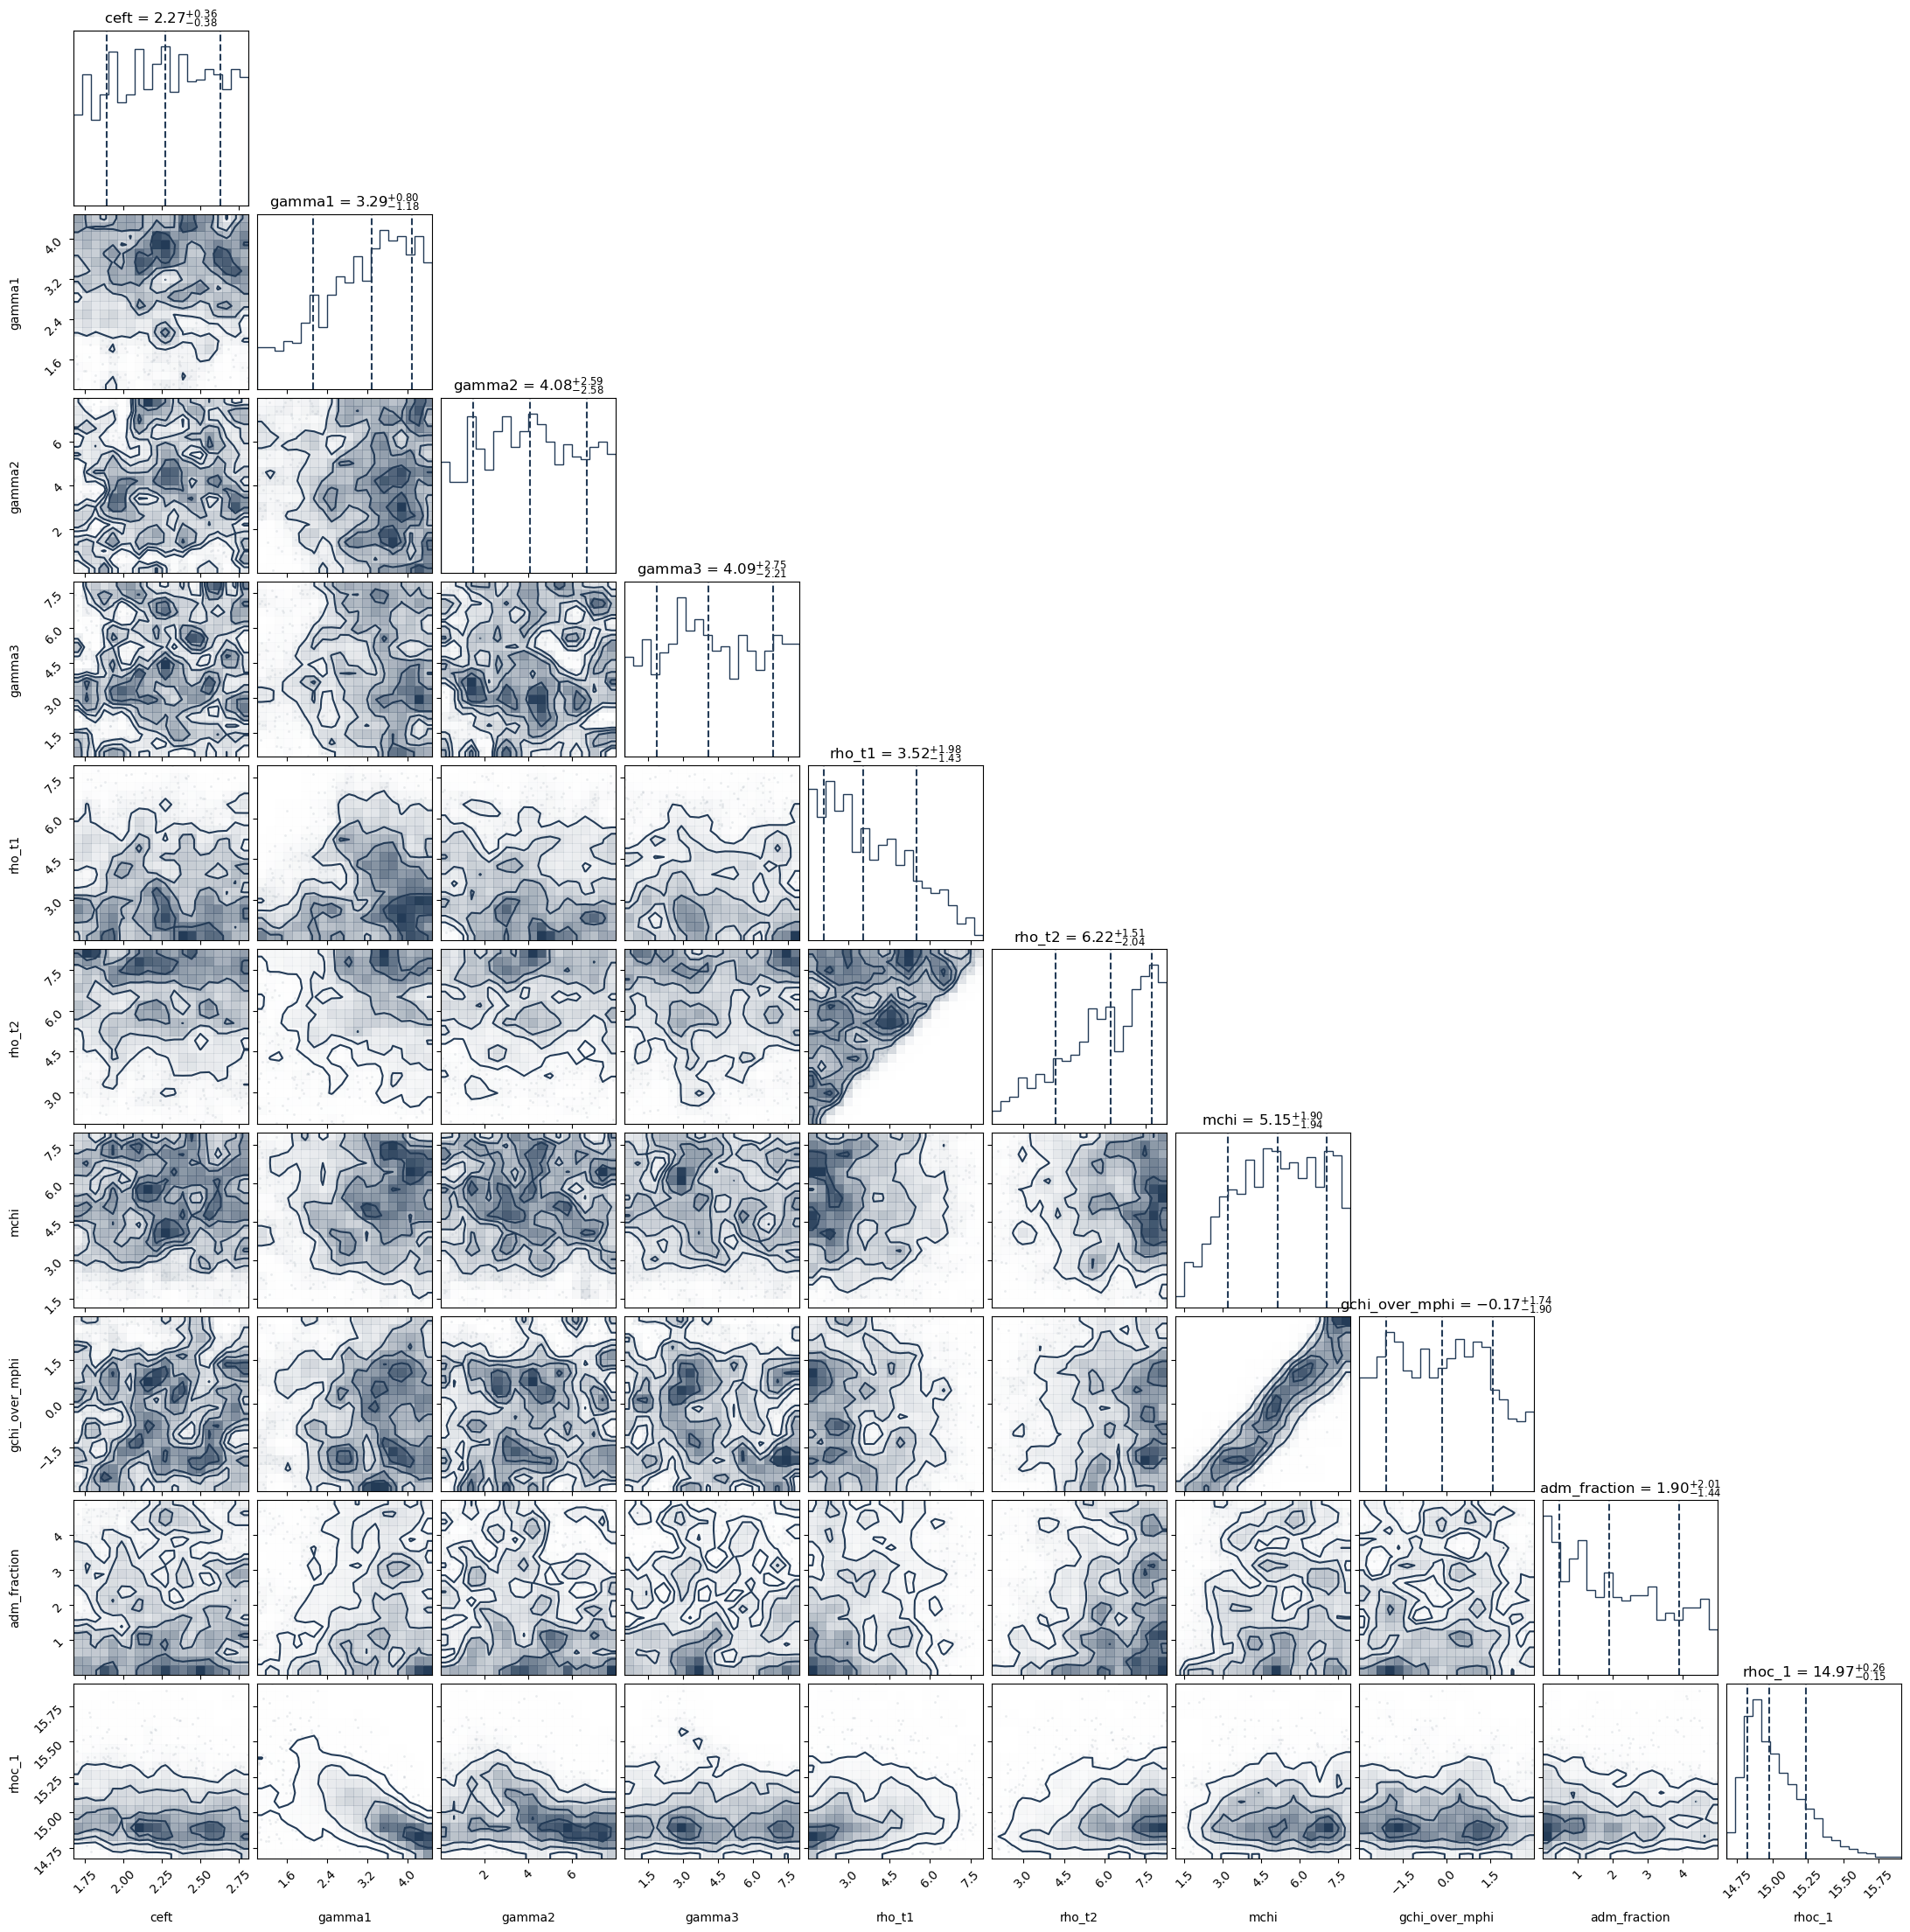

In [7]:
PosteriorAnalysis.cornerplot('chains/' + run_name, variable_params, dm = True)

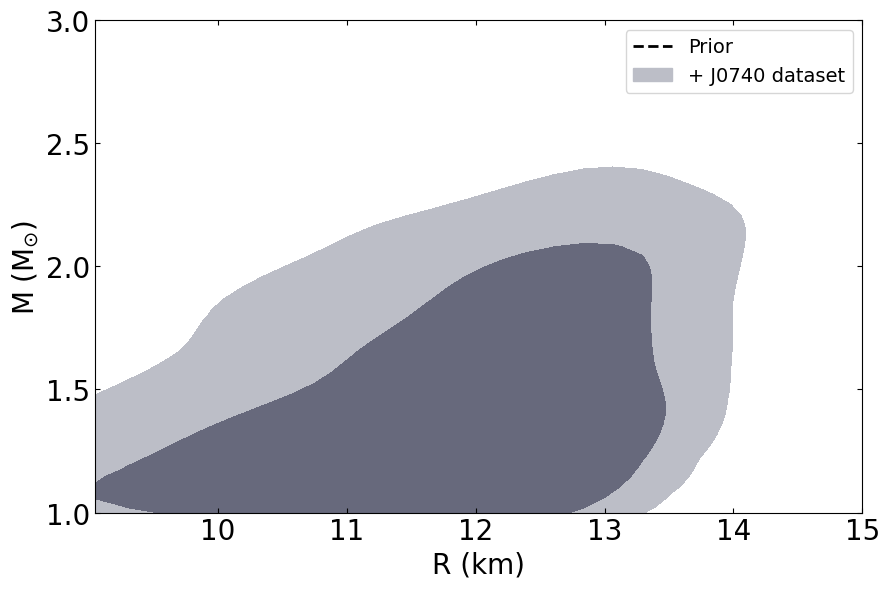

In [9]:
PosteriorAnalysis.mass_radius_prior_predictive_plot('chains/' + run_name,variable_params, label_name='+ J0740 dataset')